In [34]:
import os
import torch
import argparse
import numpy as np
from PIL import Image
from random import choice
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from train import DataProcessing, Classifier, check_command_line_arguments




def get_input_args():
    # Create Parse using ArgumentParser
    parser = argparse.ArgumentParser()

    # Create command line arguments using add_argument() from ArguementParser method
    # 'flowers/test/53/image_03717.jpg'
    parser.add_argument('--img', type = str, default = Prediction().random_image('flowers/test'), help = 'testing image path')
    parser.add_argument('--top_k', type = int, default = 3, help = 'top suggested classes')
    parser.add_argument('--checkpoint', type = str, default = 'checkpoint.pth', help = 'saved model to load')
    parser.add_argument('--category_names', type = str, default = 'cat_to_name.json', help = 'saved model to load')
    parser.add_argument('--gpu', type = str, default = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), help = 'device use to train the model on')
    return parser.parse_args()



class Prediction:
    def __init__(self):
        pass

    def random_image(self, img_dir):
        imgs_lst = [os.path.join(img_dir, cls, img) for cls in os.listdir(img_dir) for img in os.listdir(os.path.join(img_dir, cls))]
        random_img_path = choice(imgs_lst)
        return random_img_path

    def process_image(self, image):
        # TODO: Process a PIL image for use in a PyTorch model
        ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
            returns an Numpy array
        '''
        with Image.open(image) as im:
            # resize the image
            img = im.resize((256, 256))
            # center cropping the image
            crop_1 = (256 - 224) / 2
            crop_2 = (256 + 224) / 2
            center_crop = img.crop((crop_1, crop_1, crop_2, crop_2))

            # converting image to numpy array
            np_image = np.array(center_crop)   # , dtype='float64'

            # normalize the image
            np_image = np_image / 255.0
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            norm_img = (np_image - mean) / std

            # transpose color channels
            norm_img = norm_img.transpose((2, 0, 1))

            # convert numpy array to tensor
            tensor_image = torch.from_numpy(norm_img)

        return tensor_image


    def predict(self, image_path, other, topk=5):
        ''' Predict the class (or classes) of an image using a trained deep learning model.
        '''
        # TODO: Implement the code to predict the class from an image file
        image = self.process_image(image_path).type(torch.FloatTensor)
        image = image.to(device)

        with torch.no_grad():
            other.model.eval()
            # model expects an input with 4 dimensions which correspond to 
            # BxCxHxW = (Batch x Channel x Height x Width).
            # Since you are testing it with only one image, you are missing the Batch (B) dimension.
            # To solve this, you can add this dimension by using unsqueeze
            log_ps = other.model(image.unsqueeze(0))
            ps = torch.exp(log_ps)

            top_p, top_class = ps.topk(topk, dim=1)
            top_p, top_class = top_p.tolist()[0], top_class.tolist()[0]
        cls_label = [k for ind in top_class for k in other.model.class_to_idx if other.model.class_to_idx.get(k) == ind]

        return top_p, cls_label


    def plot_top_class(self, img_path, top_props, class_labels, cat_to_name):
        img = self.process_image(img_path)

        cls_names = [cat_to_name[k] for ind in class_labels for k in cat_to_name if k == ind]

        plt.figure(figsize = (6,10))
        ax = plt.subplot(2, 1, 1)
        DataProcessing().imshow(img, ax=ax, title=cls_names[0]);

        ax = plt.subplot(2, 1, 2)
        ax.barh(range(len(cls_names)), top_props, tick_label=cls_names);
        ax.invert_yaxis()
        plt.show()





# if __name__ == "__main__":
# receive command line arguments from user
# in_arg = get_input_args()

# Function that checks command line arguments using in_arg
# check_command_line_arguments(in_arg)

# set the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"You are training your model on --- {device} ---\n\n")

# get random image to test the model
random_img_path = Prediction().random_image('flowers/test')

# create the classifier
classifier = Classifier()

# load the model
classifier.load_model('checkpoint.pth')

# make prediction on the image
top_p, cls_label = Prediction().predict(random_img_path, classifier, 3)
print(top_p)
print(cls_label)

# define category_names dict
cat_to_name = Classifier().load_json_data('cat_to_name.json')
print(cat_to_name)

# plot the predicted image with its name ant the top suggested classes
Prediction().plot_top_class(random_img_path, top_p, cls_label, cat_to_name)

[0.9295580387115479, 0.053197965025901794, 0.007559893187135458]
['94', '40', '84']
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42

In [32]:
# plot the predicted image with its name ant the top suggested classes
Prediction().plot_top_class(random_img_path, top_p, cls_label, cat_to_name)

In [2]:
import os
import torch
import argparse
import numpy as np
from PIL import Image
from random import choice
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from train import DataProcessing, Classifier, check_command_line_arguments




class Prediction:
    def __init__(self):
        pass

    def random_image(self, img_dir):
        imgs_lst = [os.path.join(img_dir, cls, img) for cls in os.listdir(img_dir) for img in os.listdir(os.path.join(img_dir, cls))]
        random_img_path = choice(imgs_lst)
        return random_img_path

    def process_image(self, image):
        # TODO: Process a PIL image for use in a PyTorch model
        ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
            returns an Numpy array
        '''
        with Image.open(image) as im:
            # resize the image
            img = im.resize((256, 256))
            # center cropping the image
            crop_1 = (256 - 224) / 2
            crop_2 = (256 + 224) / 2
            center_crop = img.crop((crop_1, crop_1, crop_2, crop_2))

            # converting image to numpy array
            np_image = np.array(center_crop)   # , dtype='float64'

            # normalize the image
            np_image = np_image / 255.0
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            norm_img = (np_image - mean) / std

            # transpose color channels
            norm_img = norm_img.transpose((2, 0, 1))

            # convert numpy array to tensor
            tensor_image = torch.from_numpy(norm_img)

        return tensor_image


    def predict(self, image_path, other, topk=5):
        ''' Predict the class (or classes) of an image using a trained deep learning model.
        '''
        # TODO: Implement the code to predict the class from an image file
        image = self.process_image(image_path).type(torch.FloatTensor)
        image = image.to(device)

        with torch.no_grad():
            other.model.eval()
            # model expects an input with 4 dimensions which correspond to 
            # BxCxHxW = (Batch x Channel x Height x Width).
            # Since you are testing it with only one image, you are missing the Batch (B) dimension.
            # To solve this, you can add this dimension by using unsqueeze
            log_ps = other.model(image.unsqueeze(0))
            ps = torch.exp(log_ps)

            top_p, top_class = ps.topk(topk, dim=1)
            top_p, top_class = top_p.tolist()[0], top_class.tolist()[0]
        cls_label = [k for ind in top_class for k in other.model.class_to_idx if other.model.class_to_idx.get(k) == ind]

        return top_p, cls_label


    def plot_top_class(self, img_path, top_props, class_labels, cat_to_name):
        img = self.process_image(img_path)

        cls_names = [cat_to_name[k] for ind in class_labels for k in cat_to_name if k == ind]

        plt.figure(figsize = (6,10))
        ax = plt.subplot(2, 1, 1)
        DataProcessing().imshow(img, ax=ax, title=cls_names[0]);

        ax = plt.subplot(2, 1, 2)
        ax.barh(range(len(cls_names)), top_props, tick_label=cls_names);
        ax.invert_yaxis()

In [ ]:
img_dir = 'flowers/test'
random_img_path = Prediction().random_image(img_dir)

processed_image = Prediction().process_image(random_img_path)

top_p, cls_label = Prediction().predict(random_img_path, classifier, topk=5)

cat_to_name = classifier.load_json_data('cat_to_name.json')

Prediction().plot_top_class(random_img_path, top_p, cls_label, cat_to_name)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warni

[0.7073041796684265, 0.06869532912969589, 0.04574921354651451]
['95', '3', '68']
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 

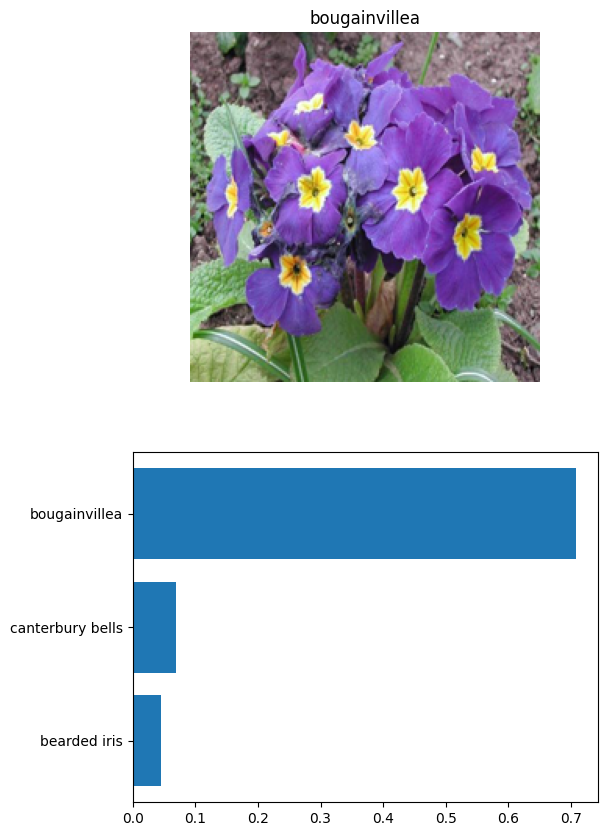

In [3]:
# set the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"You are training your model on --- {device} ---\n\n")

# get random image to test the model
random_img_path = Prediction().random_image('flowers/test')

# create the classifier
classifier = Classifier()

# load the model
classifier.load_model('checkpoint.pth')

# make prediction on the image
top_p, cls_label = Prediction().predict(random_img_path, classifier, 3)
print(top_p)
print(cls_label)

# define category_names dict
cat_to_name = Classifier().load_json_data('cat_to_name.json')
print(cat_to_name)

# plot the predicted image with its name ant the top suggested classes
Prediction().plot_top_class(random_img_path, top_p, cls_label, cat_to_name)